# Data

In [1]:
import gdown
file_id = '1of6Pl69670LZO7YWuv78KJ-iy10wzbNy'
output_path = '/kaggle/working/data'
gdown.download(f'https://drive.google.com/uc?id={file_id}', output_path, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1of6Pl69670LZO7YWuv78KJ-iy10wzbNy
From (redirected): https://drive.google.com/uc?id=1of6Pl69670LZO7YWuv78KJ-iy10wzbNy&confirm=t&uuid=04b7928d-bdfa-464b-aa1e-a451abb0c1bc
To: /kaggle/working/data
100%|██████████| 3.94G/3.94G [00:46<00:00, 84.9MB/s]


'/kaggle/working/data'

In [3]:
!unzip '/kaggle/working/data' -d '/kaggle/working/Data'

Archive:  /kaggle/working/data
   creating: /kaggle/working/Data/test/
   creating: /kaggle/working/Data/train/
   creating: /kaggle/working/Data/val/
   creating: /kaggle/working/Data/train/haslumen/
   creating: /kaggle/working/Data/train/nolumen/
  inflating: /kaggle/working/Data/train/haslumen/case_M_20181025093921_0U62363102537521_1_002_001-1_a10_ayy_image0110.jpg  
  inflating: /kaggle/working/Data/train/haslumen/chinese_case_61_f_0021_positive.jpg  
  inflating: /kaggle/working/Data/train/haslumen/case_M_20181024134247_0U62368102492146_1_002_001-1_Negative_ayy_image003862.jpg  
  inflating: /kaggle/working/Data/train/haslumen/case_M_20181024134247_0U62368102492146_1_002_001-1_Negative_ayy_image005956.jpg  
  inflating: /kaggle/working/Data/train/haslumen/case_M_20181024134247_0U62368102492146_1_002_001-1_Negative_ayy_image000526.jpg  
  inflating: /kaggle/working/Data/train/haslumen/case_M_20181024134247_0U62368102492146_1_002_001-1_Negative_ayy_image002949.jpg  
  inflating: /k

In [ ]:
import torch, torch.nn as nn
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np

train_base = T.Compose([
    T.Resize((224,224)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

# Datasets: Train Dset comes later
val_ds = ImageFolder('/kaggle/working/Data/val', transform=train_base)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2)

test_ds = ImageFolder('/kaggle/working/Data/test', transform=train_base)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2)

# Model


In [5]:
import torch.nn as nn
import torchvision.models as models
from torchsummary import summary

class SqueezeNetBinary(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = models.squeezenet1_1(weights=False)
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Conv2d(512, 32, kernel_size=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1,1))
        )
        self.fc = nn.Linear(32, 1)
        nn.init.normal_(self.fc.weight, std=0.01)
        nn.init.constant_(self.fc.bias, 0.1)

    def forward(self, x):
        x = self.backbone.features(x)
        x = self.backbone.classifier(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

# Move the model to the desired device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
model = SqueezeNetBinary().to(device)

# Print the model summary
summary(model, input_size=(3, 224, 224))

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 111, 111]           1,792
              ReLU-2         [-1, 64, 111, 111]               0
         MaxPool2d-3           [-1, 64, 55, 55]               0
            Conv2d-4           [-1, 16, 55, 55]           1,040
              ReLU-5           [-1, 16, 55, 55]               0
            Conv2d-6           [-1, 64, 55, 55]           1,088
              ReLU-7           [-1, 64, 55, 55]               0
            Conv2d-8           [-1, 64, 55, 55]           9,280
              ReLU-9           [-1, 64, 55, 55]               0
             Fire-10          [-1, 128, 55, 55]               0
           Conv2d-11           [-1, 16, 55, 55]           2,064
             ReLU-12           [-1, 16, 55, 55]               0
           Conv2d-13           [-1, 64, 55, 55]           1,088
             ReLU-14           [-1, 64,

# Hyperparamter search

In [6]:
import torch.optim as optim
from sklearn.metrics import accuracy_score
from ray import tune

def train_ray(config):

    train_set = ImageFolder("/kaggle/working/Data/train", transform=train_base)

    train_loader = DataLoader(train_set, batch_size=config["batch_size"], shuffle=True)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(model.parameters(), lr=config["lr"], momentum=0.9, weight_decay=config["weight_decay"])

    for epoch in range(config["epochs"]):
        # ---- Training ----
        model.train()
        total_loss = 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device).unsqueeze(1).float()

            optimizer.zero_grad()
            out = model(imgs)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * imgs.size(0)

        train_loss = total_loss / len(train_loader.dataset)

        # ---- Validation ----
        model.eval()
        v_preds, v_labs = [], []
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device).unsqueeze(1).float()
                out = model(imgs)
                preds = (torch.sigmoid(out) > 0.5).int().cpu().numpy().flatten()
                v_preds.extend(preds)
                v_labs.extend(labels.cpu().numpy().flatten())

        val_acc = accuracy_score(v_labs, v_preds)

        # Report to Ray Tune
        tune.report({"train_loss": train_loss, "val_acc": val_acc})


In [7]:
import ray

# Kill previous Ray sessions (if any)
!ray stop
ray.shutdown()

# Start Ray with automatic CPU/GPU detection
ray.init(ignore_reinit_error=True, include_dashboard=False)

Did not find any active Ray processes.


2025-09-09 10:29:30,260	INFO worker.py:1917 -- Started a local Ray instance.


RayContext(dashboard_url='', python_version='3.11.13', ray_version='2.47.1', ray_commit='61d3f2f1aa33563faa398105f4abda88cb39440b')

In [8]:
print(ray.available_resources())

{'memory': 21276192359.0, 'node:172.19.2.2': 1.0, 'accelerator_type:T4': 1.0, 'CPU': 4.0, 'GPU': 2.0, 'object_store_memory': 9118368153.0, 'node:__internal_head__': 1.0}


In [9]:
from ray.tune.schedulers import ASHAScheduler

search_space = {
    "lr": tune.loguniform(1e-4, 1e-1),
    "batch_size": tune.choice([16, 32, 64]),
    "weight_decay": tune.loguniform(1e-6, 1e-2),
    "epochs": 5  # per trial
}

scheduler = ASHAScheduler(
    metric="val_acc",
    mode="max",
    max_t=5,
    grace_period=1,
    reduction_factor=2
)

analysis = tune.run(
    train_ray,
    resources_per_trial={"cpu": 0.4, "gpu": 0.2 if torch.cuda.is_available() else 0},
    config=search_space,
    num_samples=10,
    scheduler=scheduler,
    name="squeezenet_hpo"
)

2025-09-09 10:30:03,844	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949
2025-09-09 10:30:03,910	INFO tensorboardx.py:193 -- pip install "ray[tune]" to see TensorBoard files.
2025-09-09 10:30:03,911	WARNING callback.py:136 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


2025-09-09 10:51:59,079	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/squeezenet_hpo' in 0.0068s.
2025-09-09 10:51:59,086	INFO tune.py:1041 -- Total run time: 1315.24 seconds (1315.16 seconds for the tuning loop).


# Augmentation

In [ ]:
import torch.optim as optim
from PIL import Image, ImageFilter

# Curriculum: blurred version
class BlurThenTensor:
    def __init__(self, radius=0):
        self.radius = radius
        self.base = T.Compose([
            T.Resize((224,224)),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
        ])
    def __call__(self, img):
        if self.radius > 0:
            img = img.filter(ImageFilter.GaussianBlur(self.radius))
        return self.base(img)


# MixUp function
def mixup(imgs, labels, alpha=0.4):
    """
    imgs: Tensor (N, C, H, W)
    labels: Tensor (N,) or (N,1) with values in {0,1} or floats (for soft labels)
    returns: mixed_imgs (N,C,H,W), mixed_labels (N,1)
    """
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(imgs.size(0), device=imgs.device)
    mixed_imgs = lam * imgs + (1 - lam) * imgs[idx]

    # normalize label shape to (N,1)
    labels = labels.float().view(-1, 1)
    labels_shuffled = labels[idx]
    mixed_labels = lam * labels + (1 - lam) * labels_shuffled
    return mixed_imgs, mixed_labels  # shape (N,C,H,W), (N,1)


# Optimizer and scheduler with optimized params
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.00242172, momentum=0.9, weight_decay=1.16095e-06)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', factor=0.3, patience=2)

# Train

In [39]:
from sklearn.metrics import accuracy_score

def train_phase(loader, mixup_enabled=False, epochs=3):
    model.train()
    for epoch in range(epochs):
        preds, labs, total_loss = [], [], 0
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device).unsqueeze(1).float()
            if mixup_enabled:
                imgs, labels = mixup(imgs, labels, alpha=0.4)

            optimizer.zero_grad()
            out = model(imgs)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()*imgs.size(0)

        print(f"Train Epoch {epoch+1}/{epochs} | Loss: {total_loss/len(loader.dataset):.4f}")

        # Validation
        model.eval()
        with torch.no_grad():
            v_preds, v_labs = [], []
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device).unsqueeze(1).float()
                out = model(imgs)
                v_preds += (torch.sigmoid(out).cpu().numpy() > 0.5).astype(int).flatten().tolist()
                v_labs += labels.cpu().numpy().flatten().tolist()
        val_acc = accuracy_score(v_labs, v_preds)
        print(f"Val Acc: {val_acc:.4f}")
        scheduler.step(val_acc)
        model.train()

In [40]:
import torch
# Progressive blurring: 3 stages × 5 epochs = 15 epochs
blur_radii = [5, 2, 0]  # decreasing blur
epochs_per_stage = 5

for stage, radius in enumerate(blur_radii, 1):
    print(f"\n=== Stage {stage} | Blur radius: {radius} ===")

    # Rebuild dataset with current blur
    train_ds = ImageFolder("/kaggle/working/Data/train", transform=BlurThenTensor(radius=radius))
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)

    # Train phase: with MixUp from the start (since model already warmed up)
    train_phase(train_loader, mixup_enabled=True, epochs=epochs_per_stage)

torch.save(model.state_dict(), "/kaggle/working/SqueezeNetEnhanced.pth")


=== Stage 1 | Blur radius: 5 ===
Train Epoch 1/5 | Loss: 0.6907
Val Acc: 0.6108
Train Epoch 2/5 | Loss: 0.6280
Val Acc: 0.7670
Train Epoch 3/5 | Loss: 0.5517
Val Acc: 0.7557
Train Epoch 4/5 | Loss: 0.5172
Val Acc: 0.7756
Train Epoch 5/5 | Loss: 0.5075
Val Acc: 0.8305

=== Stage 2 | Blur radius: 2 ===
Train Epoch 1/5 | Loss: 0.4818
Val Acc: 0.8191
Train Epoch 2/5 | Loss: 0.4775
Val Acc: 0.5000
Train Epoch 3/5 | Loss: 0.4705
Val Acc: 0.8248
Train Epoch 4/5 | Loss: 0.4567
Val Acc: 0.8523
Train Epoch 5/5 | Loss: 0.4444
Val Acc: 0.8030

=== Stage 3 | Blur radius: 0 ===
Train Epoch 1/5 | Loss: 0.4495
Val Acc: 0.8636
Train Epoch 2/5 | Loss: 0.4322
Val Acc: 0.8210
Train Epoch 3/5 | Loss: 0.4315
Val Acc: 0.6903
Train Epoch 4/5 | Loss: 0.4283
Val Acc: 0.8684
Train Epoch 5/5 | Loss: 0.4331
Val Acc: 0.8769


In [41]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

if not model:
    squeezenet_model = SqueezeNetBinary().to(device)
    squeezenet_model.load_state_dict(torch.load("/kaggle/working/SqueezeNetEnhanced.pth", map_location=device))

model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = torch.sigmoid(outputs).cpu()
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.unsqueeze(1).numpy())

import numpy as np
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

acc = accuracy_score(all_labels, all_preds > 0.5)
f1 = f1_score(all_labels, all_preds > 0.5)
auc = roc_auc_score(all_labels, all_preds)

print(f"Test Accuracy: {acc:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")

Test Accuracy: 0.8532, F1: 0.8485, AUC: 0.9286


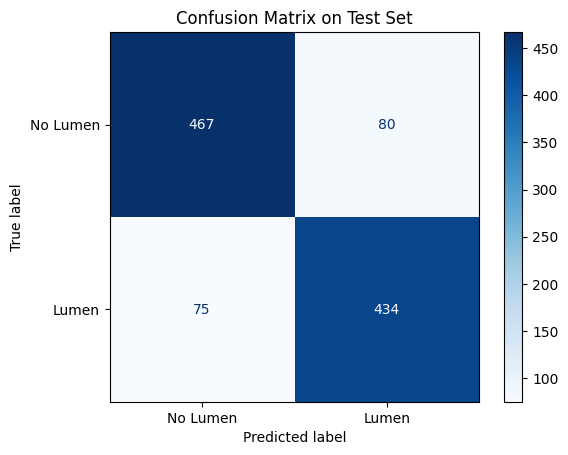

In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds > 0.5)

# Display 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Lumen", "Lumen"])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix on Test Set")
plt.show()



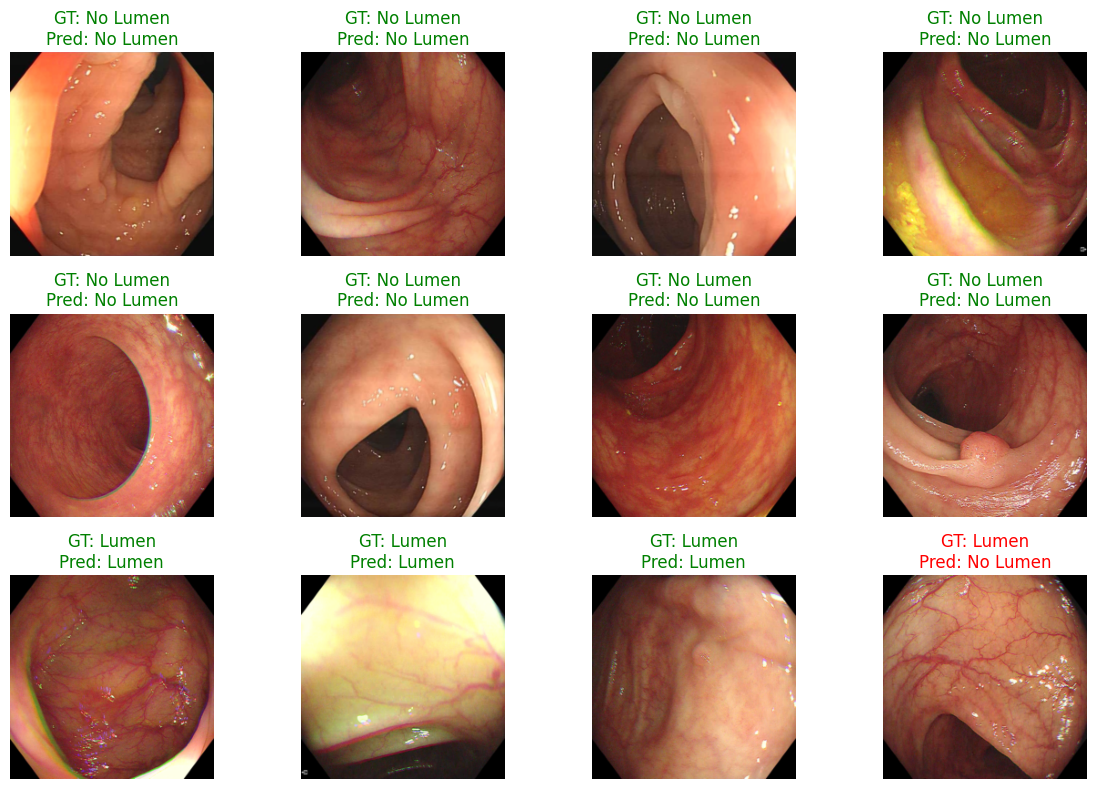

In [46]:
import numpy as np
import random

model.eval()
all_data = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        logits = model(imgs)
        probs = torch.sigmoid(logits).cpu().squeeze()
        preds = (probs > 0.5).int()
        
        # Collect all data
        for i in range(len(imgs)):
            # Convert tensors to numpy for easy storage and later plotting
            img_np = imgs[i].cpu().permute(1, 2, 0).numpy()
            true_label = labels[i].item()
            pred_label = preds[i].item()
            all_data.append((img_np, true_label, pred_label))

# Sample 12 random images from the collected data
if len(all_data) >= 12:
    random_samples = random.sample(all_data, 12)
else:
    random_samples = all_data # Take all if less than 12
    
plt.figure(figsize=(12, 8))

for idx, (img_np, true_label, pred_label) in enumerate(random_samples):
    # Denormalize the image
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_np = img_np * std + mean
    img_np = np.clip(img_np, 0, 1)

    # Prepare labels for plotting
    true_text = "Lumen" if true_label == 1 else "No Lumen"
    pred_text = "Lumen" if pred_label == 1 else "No Lumen"
    color = 'green' if true_text == pred_text else 'red'
    
    # Plot the image
    plt.subplot(3, 4, idx + 1)
    plt.imshow(img_np)
    plt.title(f"GT: {true_text}\nPred: {pred_text}", color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()

# ONNX 

## SetUP

In [15]:
import torch
import onnx

model = SqueezeNetBinary().to(device)
model.load_state_dict(torch.load("/kaggle/input/squeezenetenhanced-model/SqueezeNetEnhanced.pth", map_location=device))
model.eval()

# Dummy input matching your training size (batch size 1)
dummy_input = torch.randn(1, 3, 224, 224, device=device)

# Export to ONNX (recommended approach using torch.onnx.export)
torch.onnx.export(
    model,
    dummy_input,
    "SqueezeNetEnhanced.onnx",
    export_params=True,
    opset_version=13,
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},
    do_constant_folding=True
)
print("ONNX model exported successfully.")

ONNX model exported successfully.


In [9]:
# Load and check the ONNX model
onnx_model = onnx.load("/kaggle/working/SqueezeNetEnhanced.onnx")
onnx.checker.check_model(onnx_model)
print("✅ ONNX model is valid!")

✅ ONNX model is valid!


In [10]:
!pip install onnxruntime-gpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.2/283.2 MB 5.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.8 MB/s eta 0:00:00


In [12]:
import onnxruntime as ort

ort_session = ort.InferenceSession(
    "/kaggle/working/SqueezeNetEnhanced.onnx",
    providers=["CPUExecutionProvider"]
)
print("ONNX Runtime session loaded with CPU support.")

ONNX Runtime session loaded with CPU support.


## Pytorch vs ONNX

In [13]:
import random
# Pick 6 random images from test set
all_imgs, all_labels = [], []
for imgs, labels in test_loader:
    all_imgs.extend(imgs)
    all_labels.extend(labels)
    if len(all_imgs) > 100:  # enough pool
        break

idxs = random.sample(range(len(all_imgs)), 6)
sample_imgs = [all_imgs[i].unsqueeze(0) for i in idxs]
sample_labels = [all_labels[i].item() for i in idxs]

# Helper: convert to numpy
def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

In [40]:
if not model:
    model = SqueezeNetBinary().to(device)
    model.load_state_dict(torch.load("/kaggle/input/squeezenetenhanced-model/SqueezeNetEnhanced.pth", map_location=device))

model.eval()
torch_preds, torch_probs = [], []

with torch.no_grad():
    for img in sample_imgs:
        logit = model(img.to(device))
        prob = torch.sigmoid(logit).item()
        pred = int(prob > 0.5)
        torch_preds.append(pred)
        torch_probs.append(prob)

In [18]:
input_name = ort_session.get_inputs()[0].name
output_name = ort_session.get_outputs()[0].name

onnx_preds, onnx_probs = [], []

for img in sample_imgs:
    img_np = to_numpy(img)
    onnx_out = ort_session.run([output_name], {input_name: img_np})[0]
    prob = 1 / (1 + np.exp(-onnx_out[0][0]))  # sigmoid
    pred = int(prob > 0.5)
    onnx_preds.append(pred)
    onnx_probs.append(prob)

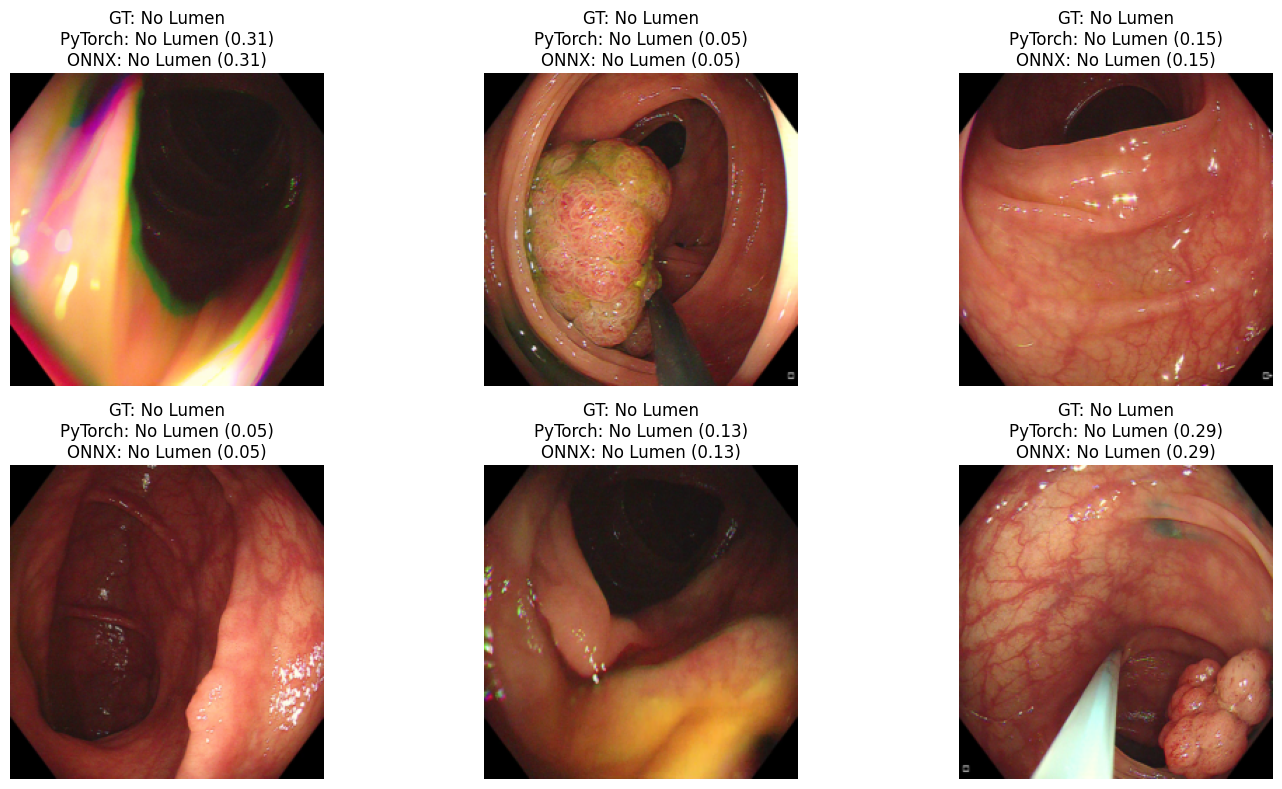

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F


plt.figure(figsize=(15, 8))

for i, img in enumerate(sample_imgs):
    # denormalize
    img_disp = img.squeeze().permute(1, 2, 0).cpu().numpy()
    img_disp = img_disp * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    img_disp = np.clip(img_disp, 0, 1)

    plt.subplot(2, 3, i+1)
    plt.imshow(img_disp)
    plt.title(
        f"GT: {'Lumen' if sample_labels[i] else 'No Lumen'}\n"
        f"PyTorch: {'Lumen' if torch_preds[i] else 'No Lumen'} ({torch_probs[i]:.2f})\n"
        f"ONNX: {'Lumen' if onnx_preds[i] else 'No Lumen'} ({onnx_probs[i]:.2f})"
    )
    plt.axis("off")

plt.tight_layout()
plt.show()


In [20]:
import time

# Benchmark PyTorch
n_runs = 100
batch_cpu = torch.cat(sample_imgs).to("cpu")   # shape [6, 3, 224, 224]
model_cpu = model.to("cpu")

start = time.time()
with torch.no_grad():
    for _ in range(n_runs):
        _ = model_cpu(batch_cpu)
torch_time = (time.time() - start) / n_runs

# Benchmark ONNX
batch_np = to_numpy(torch.cat(sample_imgs))

start = time.time()
for _ in range(n_runs):
    _ = ort_session.run([output_name], {input_name: batch_np})
onnx_time = (time.time() - start) / n_runs

print(f"Avg PyTorch inference time per batch: {torch_time*1000:.3f} ms")
print(f"Avg ONNXRuntime inference time per batch: {onnx_time*1000:.3f} ms")

Avg PyTorch inference time per batch: 98.930 ms
Avg ONNXRuntime inference time per batch: 20.431 ms


## Quantization

### SetUp

In [21]:
import torch.quantization as tq

model_int8 = tq.quantize_dynamic(
    model_cpu,
    {torch.nn.Linear, torch.nn.Conv2d}, 
    dtype=torch.qint8
).cpu().eval()

In [28]:
from onnxruntime.quantization import quantize_static, QuantType, CalibrationDataReader

class MyCalibrationReader(CalibrationDataReader):
    def __init__(self, data_loader):
        self.data_iter = iter(data_loader)
    def get_next(self):
        try:
            imgs, _ = next(self.data_iter)
            return {"input": imgs.numpy()}  # must match ONNX input name
        except StopIteration:
            return None

calib_reader = MyCalibrationReader(val_loader)

quantize_static(
    model_input="/kaggle/working/SqueezeNetEnhanced.onnx",
    model_output="squeezenet_int8_static.onnx",
    calibration_data_reader=calib_reader,
    weight_type=QuantType.QInt8
)

ort_session_int8 = ort.InferenceSession("squeezenet_int8_static.onnx")
print([inp.name for inp in ort_session.get_inputs()])

['input']


### Speed

In [25]:
# Run benchmark on CPU
with torch.no_grad():
    start = time.time()
    for _ in range(100):
        _ = model_int8(batch_cpu)
torch_time_int8 = (time.time() - start) / 100
print(f"PyTorch int8 inference time per batch (CPU): {torch_time_int8*1000:.3f} ms")


PyTorch int8 inference time per batch (CPU): 103.658 ms


In [30]:
start = time.time()
for _ in range(100):
    _ = ort_session_int8.run([output_name], {input_name: batch_np})
onnx_time_int8 = (time.time() - start) / 100
print(f"ONNX int8 inference time per batch: {onnx_time_int8*1000:.3f} ms")

ONNX int8 inference time per batch: 55.911 ms


### Accuracy

In [31]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

nput_name = ort_session_int8.get_inputs()[0].name
output_name = ort_session_int8.get_outputs()[0].name

def torch_infer(model, loader, device="cpu"):
    preds, gts = [], []
    with torch.no_grad():
        for imgs, labels in loader:
            logits = model(imgs.to(device))
            probs = torch.sigmoid(logits).squeeze()
            batch_preds = (probs > 0.5).int().cpu().numpy()
            preds.extend(batch_preds)
            gts.extend(labels.numpy())
    return np.array(preds), np.array(gts)

def onnx_infer(session, loader):
    preds, gts = [], []
    for imgs, labels in loader:
        batch_np = imgs.numpy()
        out = session.run([output_name], {input_name: batch_np})[0]
        probs = 1 / (1 + np.exp(-out.squeeze()))
        batch_preds = (probs > 0.5).astype(int)
        preds.extend(batch_preds)
        gts.extend(labels.numpy())
    return np.array(preds), np.array(gts)


print("Evaluating models...")

# PyTorch int8
int8_preds_torch, int8_gts_torch = torch_infer(model_int8, test_loader, "cpu")
int8_acc_torch = accuracy_score(int8_gts_torch, int8_preds_torch)
f1_torch = f1_score(int8_gts_torch, int8_preds_torch > 0.5)
auc_torch = roc_auc_score(int8_gts_torch, int8_preds_torch)

# ONNX int8
int8_preds_onnx, int8_gts_onnx = onnx_infer(ort_session_int8, test_loader)
int8_acc_onnx = accuracy_score(int8_gts_onnx, int8_preds_onnx)
f1_onnx = f1_score(int8_gts_onnx, int8_preds_onnx > 0.5)
auc_onnx = roc_auc_score(int8_gts_onnx, int8_preds_onnx)

print(f"PyTorch INT8 Accuracy: {int8_acc_torch:.4f}, F1_torch: {f1_torch:.4f}, AUC_torch: {auc_torch:.4f}")
print(f"ONNX INT8 Accuracy: {int8_acc_onnx:.4f}, F1_onnx: {f1_onnx:.4f}, AUC_onnx: {auc_onnx:.4f}")

Evaluating models...
PyTorch INT8 Accuracy: 0.8627, F1_torch: 0.8574, AUC_torch: 0.8625
ONNX INT8 Accuracy: 0.8513, F1_onnx: 0.8465, AUC_onnx: 0.8513


# Knowledge distilation

## Load 

In [3]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as T

train_base = T.Compose([
    T.Resize((224,224)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])
# Datasets
train_ds = ImageFolder('/kaggle/working/Data/train', transform=train_base)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=False, num_workers=2)

val_ds = ImageFolder('/kaggle/working/Data/val', transform=train_base)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2)

test_ds = ImageFolder('/kaggle/working/Data/test', transform=train_base)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2)

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Teacher
teacher = models.mobilenet_v3_small(weights=None)
teacher.classifier[3] = nn.Linear(1024, 1)  # keep original 1 output

t_ckpt = torch.load("/kaggle/input/mobilenetv3/mobnetv3s_best_param_f1_focal.pth")
teacher.load_state_dict(t_ckpt, strict=False)

# Student
class SqueezeNetBinary(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = models.squeezenet1_1(weights=None)
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Conv2d(512, 32, kernel_size=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.fc = nn.Linear(32, 2)  # now 2-class head
    def forward(self, x):
        x = self.backbone.features(x)
        x = self.backbone.classifier(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

student = SqueezeNetBinary()


In [40]:
# Student checkpoint
s_ckpt = torch.load("/kaggle/input/squeezenetenhanced-model/SqueezeNetEnhanced.pth")

w = s_ckpt['fc.weight']
b = s_ckpt['fc.bias']
s_ckpt['fc.weight'] = torch.cat([w, w], dim=0)
s_ckpt['fc.bias'] = torch.cat([b, b], dim=0)

student.load_state_dict(s_ckpt, strict=False)

teacher.to(device)
student.to(device)

# Teacher stays frozen
teacher.eval()
for p in teacher.parameters():
    p.requires_grad = False

## Train

In [29]:
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

optimizer = Adam(student.parameters(), lr=0.00242172, weight_decay=1.16095e-06)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

# Hard loss (ground truth)
hard_criterion = nn.CrossEntropyLoss()   # since student has 2 outputs

# Soft loss (teacher vs student, with temperature)
def distillation_loss(student_logits, teacher_probs, T=4.0):
    # scale student
    s_log_probs = F.log_softmax(student_logits / T, dim=1)
    # teacher already in prob space
    t_probs = F.softmax(teacher_probs / T, dim=1)
    return F.kl_div(s_log_probs, t_probs, reduction="batchmean") * (T * T)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [43]:
from sklearn.metrics import accuracy_score

def train_student(student, teacher, train_loader, val_loader, optimizer, scheduler,
                  epochs=10, alpha=0.7, T=3.0):
    for epoch in range(epochs):
        student.train()
        total_loss = 0
        preds_list, labels_list = [], []

        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
        
            # Teacher forward (1 output -> expand to 2 probs)
            with torch.no_grad():
                t_logits = teacher(imgs)                # [B, 1]
                t_probs = torch.sigmoid(t_logits)       # [B, 1]
                t_probs = torch.cat([1 - t_probs, t_probs], dim=1)  # [B, 2]
        
            # Student forward
            s_logits = student(imgs)                      # [B, 2]
        
            # Hard loss (student vs true label)
            hard_loss = hard_criterion(s_logits, labels)
        
            # Soft loss (student vs teacher)
            soft_loss = distillation_loss(s_logits, t_probs, T=4.0)
        
            # Combined
            loss = alpha * hard_loss + (1 - alpha) * soft_loss

        
            # ---- Backprop ----
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


            total_loss += loss.item() * imgs.size(0)

            batch_preds = s_logits.argmax(dim=1).cpu().numpy().tolist()
            preds_list += batch_preds
            labels_list += labels.cpu().numpy().tolist()

        train_loss = total_loss / len(train_loader.dataset)
        train_acc = accuracy_score(labels_list, preds_list)

        # Validation
        student.eval()
        v_preds, v_labels = [], []
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                out = student(imgs)
                batch_preds = out.argmax(dim=1).cpu().numpy().tolist()
                v_preds += batch_preds
                v_labels += labels.cpu().numpy().tolist()
        val_acc = accuracy_score(v_labels, v_preds)

        scheduler.step(val_acc)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f} | "
              f"Val Acc: {val_acc*100:.2f}")


In [48]:
train_student(student, teacher, train_loader, val_loader, optimizer, scheduler,
              epochs=10, alpha=0.7, T=3.0)

torch.save(student.state_dict(), "squeezenet_student_distilled.pth")

Epoch  1 | Train Loss: 0.3576 | Train Acc: 0.8637 | Val Acc: 0.8682
Epoch  2 | Train Loss: 0.3351 | Train Acc: 0.8741 | Val Acc: 0.8076
Epoch  3 | Train Loss: 0.3320 | Train Acc: 0.8766 | Val Acc: 0.8872
Epoch  4 | Train Loss: 0.3113 | Train Acc: 0.8893 | Val Acc: 0.7972
Epoch  5 | Train Loss: 0.3033 | Train Acc: 0.8892 | Val Acc: 0.8739
Epoch  6 | Train Loss: 0.2905 | Train Acc: 0.8967 | Val Acc: 0.9033
Epoch  7 | Train Loss: 0.2830 | Train Acc: 0.9016 | Val Acc: 0.7508
Epoch  8 | Train Loss: 0.2798 | Train Acc: 0.9033 | Val Acc: 0.5150
Epoch  9 | Train Loss: 0.2758 | Train Acc: 0.9087 | Val Acc: 0.7281
Epoch 10 | Train Loss: 0.2608 | Train Acc: 0.9115 | Val Acc: 0.8313


## Evaluate

In [52]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

if not model:
    squeezenet_model = SqueezeNetBinary().to(device)
    squeezenet_model.load_state_dict(torch.load("/kaggle/input/SqueezenetDistilled/squeezenet_student_distilled.pth", map_location=device))
True
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = torch.sigmoid(outputs).cpu()
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.unsqueeze(1).numpy())

import numpy as np
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

acc = accuracy_score(all_labels, all_preds > 0.5)
f1 = f1_score(all_labels, all_preds > 0.5)
auc = roc_auc_score(all_labels, all_preds)

print(f"Test Accuracy: {acc:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")

Test Accuracy: 0.8738, F1: 0.8501, AUC: 0.9291


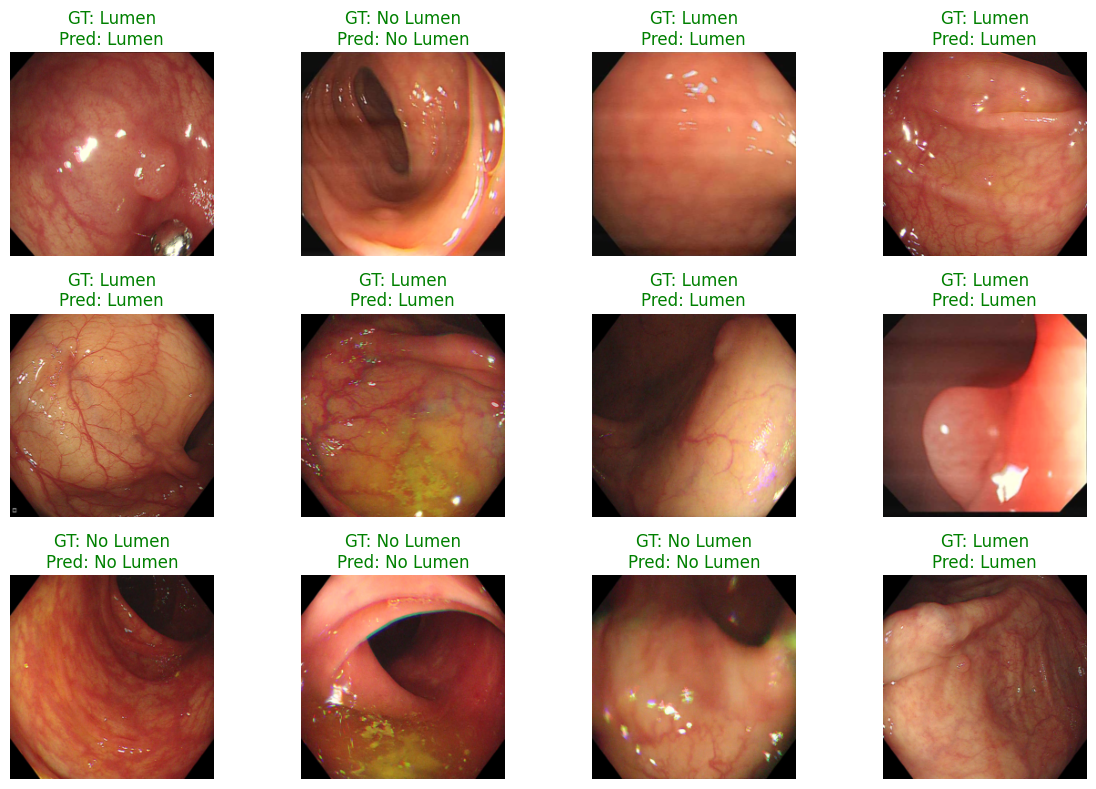

In [54]:
import matplotlib.pyplot as plt
import numpy as np
import random

model.eval()
all_data = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        logits = model(imgs)
        probs = torch.sigmoid(logits).cpu().squeeze()
        preds = (probs > 0.5).int()
        
        # Collect all data
        for i in range(len(imgs)):
            # Convert tensors to numpy for easy storage and later plotting
            img_np = imgs[i].cpu().permute(1, 2, 0).numpy()
            true_label = labels[i].item()
            pred_label = preds[i].item()
            all_data.append((img_np, true_label, pred_label))

# Sample 12 random images from the collected data
if len(all_data) >= 12:
    random_samples = random.sample(all_data, 12)
else:
    random_samples = all_data # Take all if less than 12
    
plt.figure(figsize=(12, 8))

for idx, (img_np, true_label, pred_label) in enumerate(random_samples):
    # Denormalize the image
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_np = img_np * std + mean
    img_np = np.clip(img_np, 0, 1)

    # Prepare labels for plotting
    true_text = "Lumen" if true_label == 1 else "No Lumen"
    pred_text = "Lumen" if pred_label == 1 else "No Lumen"
    color = 'green' if true_text == pred_text else 'red'
    
    # Plot the image
    plt.subplot(3, 4, idx + 1)
    plt.imshow(img_np)
    plt.title(f"GT: {true_text}\nPred: {pred_text}", color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()